Vehicle Tracking Pipeline

Steps

1 load data set generate training and test set - ensuring there are enough samples in each
2 look at a number of colour spaces to classify cars - try HLS, HSV ....
3 generate sliding window function
4 calcualte HOG 1 time
5 Carry out training
6 build pipeline

In [1]:
#Import dependancies
import glob

import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

In [2]:
noCar = []
for image in glob.glob("non-vehicles/non-vehicles/*/*.png"):
    noCar=np.append(noCar,image)
print (len(noCar))

8968


In [3]:
car = []
for image in glob.glob("vehicles/vehicles/*/*.png"):
    car=np.append(car,image)
print (len(car))

8792


So I have roughly 2x as many car images as not car images. I could supplement the noCar data set by data augmentation but for now I will just take a small sample of 50 from each data set for further exploration.

In [4]:
from sklearn.utils import shuffle
carShuffle = shuffle(car)
carSubset = shuffle(carShuffle, n_samples = 50)
noCarShuffle = shuffle(noCar)
noCarSubset = shuffle(noCarShuffle, n_samples = 50)

In [5]:
# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    ch0 = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ch1 = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    ch2 = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = ch0[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Return the individual histograms, bin_centers and feature vector
    return ch0, ch1, ch2, bin_centers

In [6]:
from skimage.feature import hog
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                              visualise=False, feature_vector=True)
    return features

In [7]:
# This function allows us to look at different coulour spaces and look at the 
# histograms for all the images in the supplied data set
def colorHist(color_space, noBins, dataSet):
    ch0Tot=np.zeros(noBins,dtype=float)
    ch1Tot=np.zeros(noBins,dtype=float)
    ch2Tot=np.zeros(noBins,dtype=float)

    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block

    for image in dataSet:
        img = mpimg.imread(image)
        if color_space=='HSV':
            imgCS=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space=='LUV':
            imgCS=cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space =='LAB':
            imgCS=cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
        elif color_space =='YCrCb':
            imgCS=cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
        elif color_space =='HLS':
            imgCS=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif color_space =='YUV':
            imgCS=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        else:
            imgCS=img
        binRange=(np.min(imgCS),np.max(imgCS))
        ch0,ch1,ch2,bincen = color_hist(imgCS, nbins=noBins, bins_range=binRange)
        ch0Tot=np.add(ch0Tot,ch0[0])
        ch1Tot=np.add(ch1Tot,ch1[0])
        ch2Tot=np.add(ch2Tot,ch2[0])

        ch0Im, ch1Im, ch2Im = cv2.split(imgCS)

    ch0F = get_hog_features(ch0Im, orient, 
                    pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True)

    ch1F = get_hog_features(ch1Im, orient, 
                    pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True)

    ch2F = get_hog_features(ch2Im, orient, 
                    pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)

    return ch0Tot, ch1Tot, ch2Tot, bincen, binRange, ch0Im, ch1Im, ch2Im, ch0F, ch1F, ch2F


In [8]:
#THis function plots the results for a given colour space on the whole
#data set
def colorSpaceCompare(colorSpace):

    rCar,gCar,bCar,bincen,binRange, carIm0, carIm1, carIm2, carHogF0, carHogF1, carHogF2 =colorHist(colorSpace,32, carSubset)

#    carHogF0 = findHog(carIm0)
#    carHogF1 = findHog(carIm1)
#    carHogF2 = findHog(carIm2)
    
    rNoCar,gNoCar,bNoCar,bincen,binRange, noCarIm0, noCarIm1, noCarIm2, noCarHogF0, noCarHogF1, noCarHogF2 =colorHist(colorSpace,32,noCarSubset)

#    noCarHogF0 = findHog(noCarIm0)
#    noCarHogF1 = findHog(noCarIm1)
#    noCarHogF2 = findHog(noCarIm2)

    #Plot colour space histograms
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.plot(bincen, rCar, 'r')
    plt.plot(bincen, rNoCar,'b')
    plt.xlim(binRange)
    plt.title('Car Ch0 Histogram')
    plt.subplot(132)
    plt.plot(bincen, gCar,'r')
    plt.plot(bincen, gNoCar,'b')
    plt.xlim(binRange)
    plt.title('Car Ch1 Histogram')
    plt.subplot(133)
    plt.plot(bincen, bCar,'r')
    plt.plot(bincen, bNoCar,'b')
    plt.xlim(binRange)
    plt.title('Car Ch2 Histogram')
    fig.tight_layout()
    
    #plot Car colour space images
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(carIm0)
    plt.title('Car Ch0 Image')
    plt.subplot(132)
    plt.imshow(carIm1)
    plt.title('Car Ch1 Image')
    plt.subplot(133)
    plt.imshow(carIm2)
    plt.title('Car Ch2 Image')
    fig.tight_layout()

    #Plot colour space histograms
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.plot(carHogF0, 'r')
    plt.plot(noCarHogF0, 'b')
    plt.title('Car Ch0 Histogram')
    plt.subplot(132)
    plt.plot(carHogF1,'r')
    plt.plot(noCarHogF1, 'b')
    plt.title('Car Ch1 Histogram')
    plt.subplot(133)
    plt.plot(carHogF2,'r')
    plt.plot(noCarHogF2, 'b')
    plt.title('Car Ch2 Histogram')
    fig.tight_layout()
    
    #plot Car Hog space images
#    fig = plt.figure(figsize=(12,3))
#    plt.subplot(131)
#    plt.imshow(carHog0)
#    plt.title('Car Ch0 Image')
#    plt.subplot(132)
#    plt.imshow(carHog1)
#    plt.title('Car Ch1 Image')
#    plt.subplot(133)
#    plt.imshow(carHog2)
#    plt.title('Car Ch2 Image')
#    fig.tight_layout()

    #plot NoCar colour space images
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(noCarIm0)
    plt.title('Car Ch0 Image')
    plt.subplot(132)
    plt.imshow(noCarIm1)
    plt.title('Car Ch1 Image')
    plt.subplot(133)
    plt.imshow(noCarIm2)
    plt.title('Car Ch2 Image')
    fig.tight_layout()

    #plot no Car Hog space images
#    fig = plt.figure(figsize=(12,3))
#    plt.subplot(131)
#    plt.imshow(noCarHog0)
#    plt.title('Car Ch0 Image')
#    plt.subplot(132)
#    plt.imshow(noCarHog1)
#    plt.title('Car Ch1 Image')
#    plt.subplot(133)
#    plt.imshow(noCarHog2)
#    plt.title('Car Ch2 Image')
#    fig.tight_layout()


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


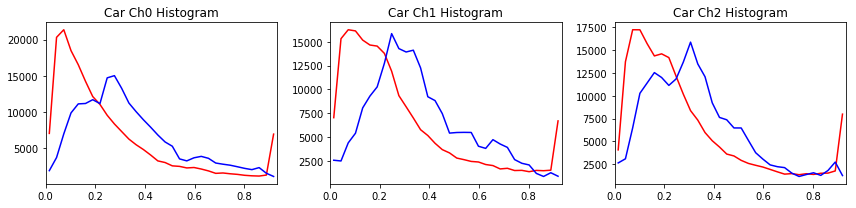

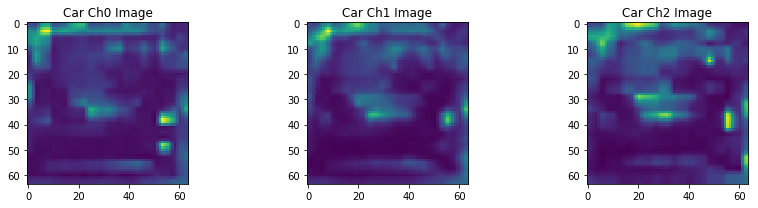

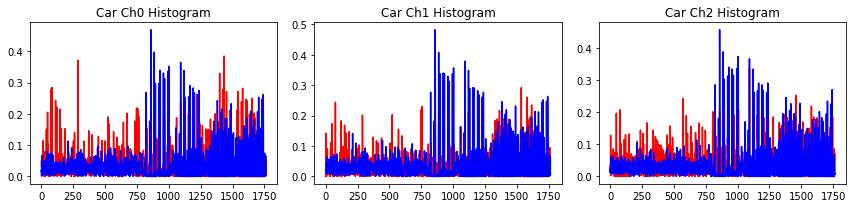

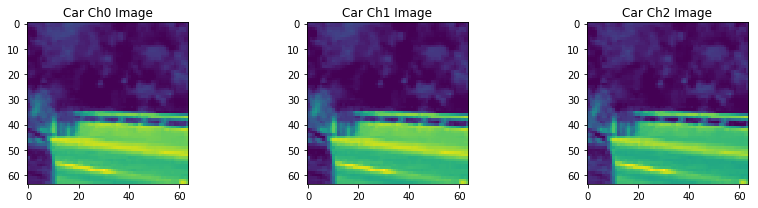

In [9]:
colorSpaceCompare('RGB')

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


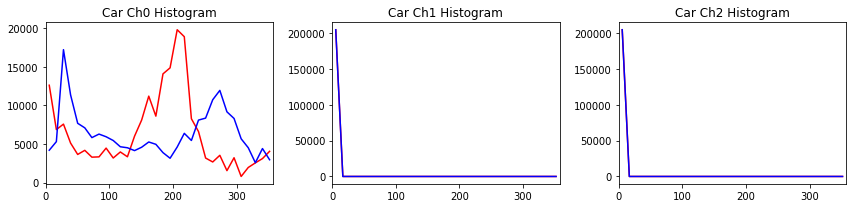

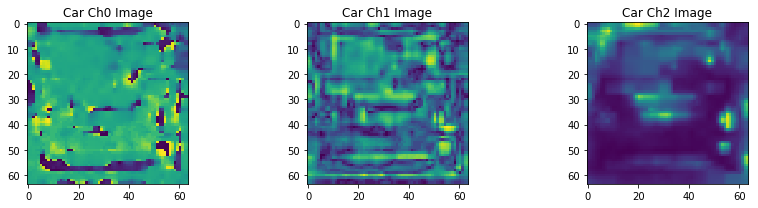

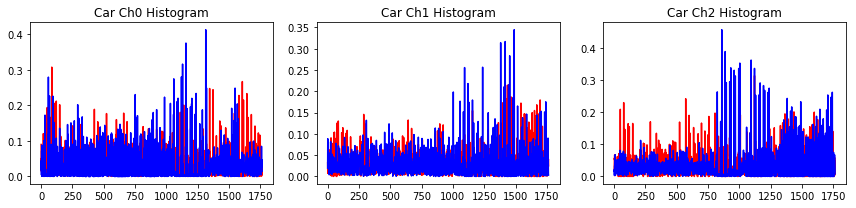

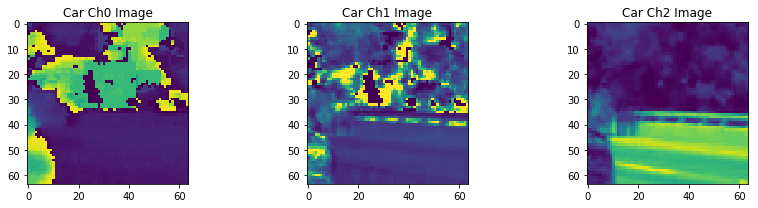

In [10]:
colorSpaceCompare('HSV')

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


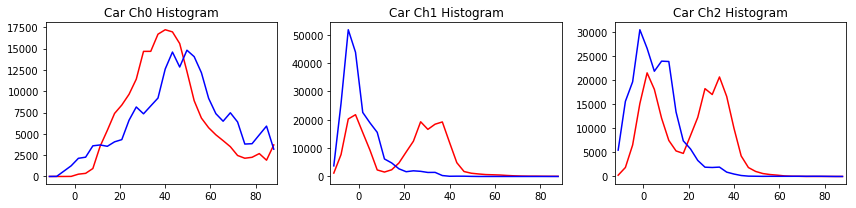

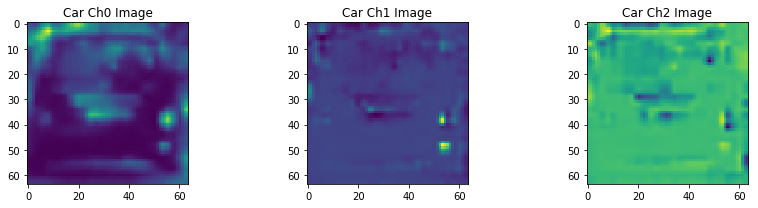

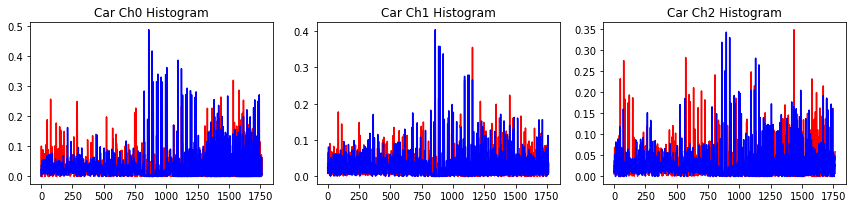

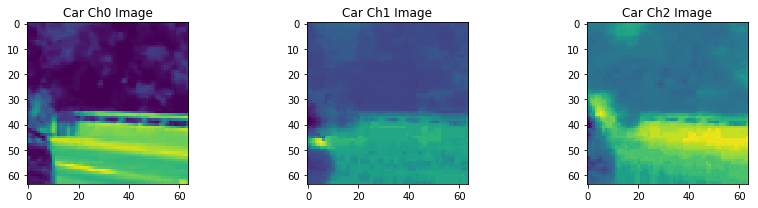

In [11]:
colorSpaceCompare('LUV')

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


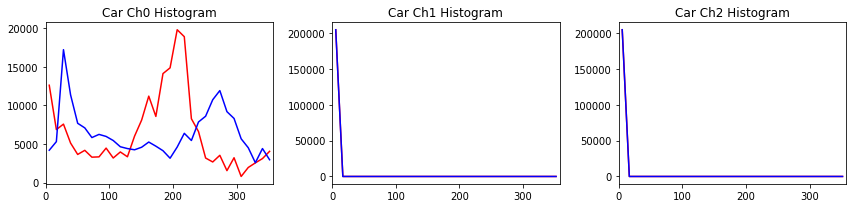

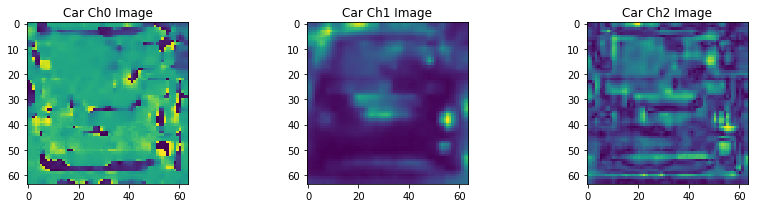

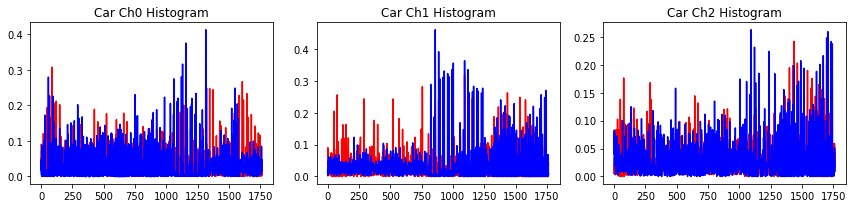

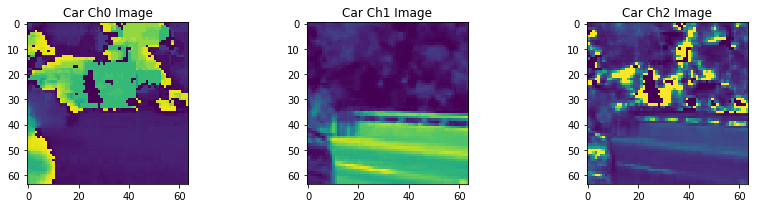

In [12]:
colorSpaceCompare('HLS')

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


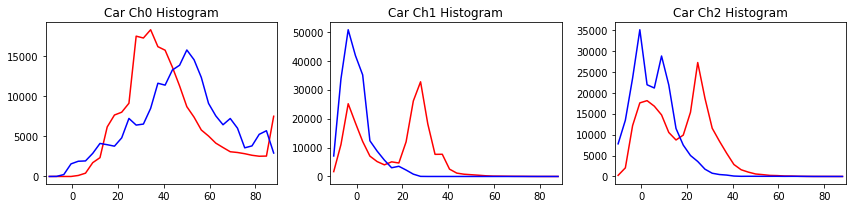

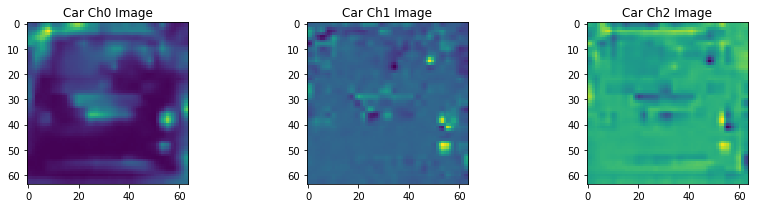

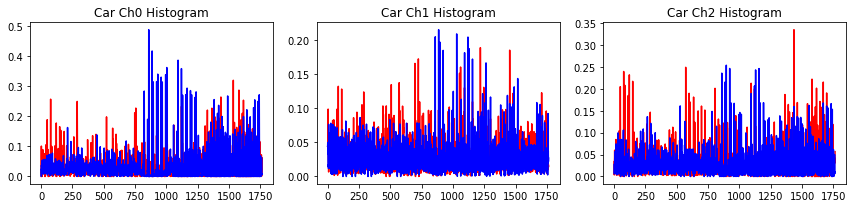

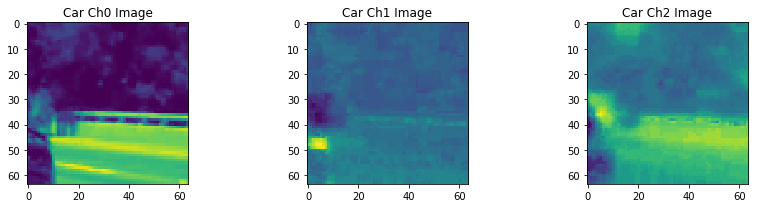

In [13]:
colorSpaceCompare('LAB')

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


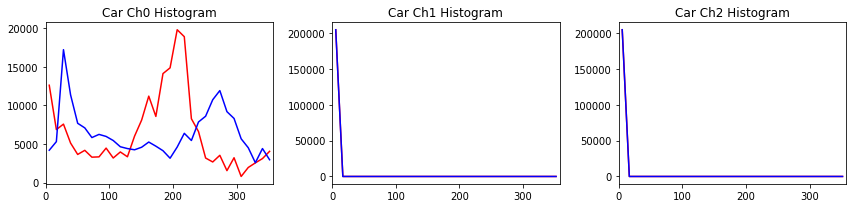

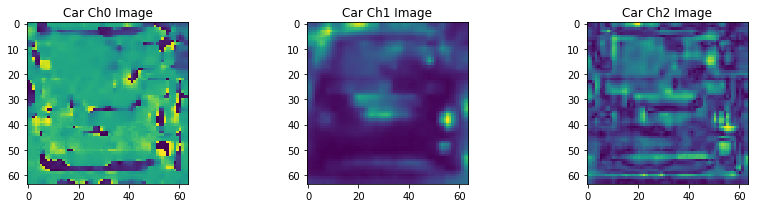

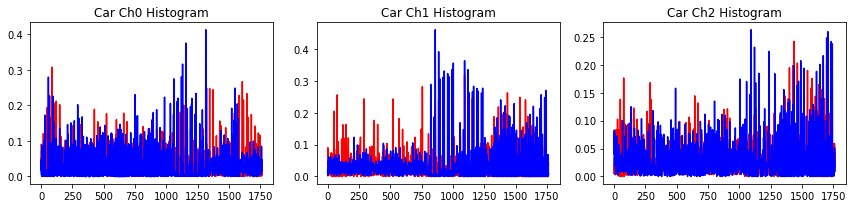

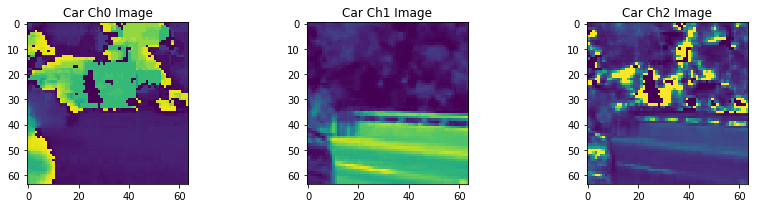

In [14]:
colorSpaceCompare('YUV')

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


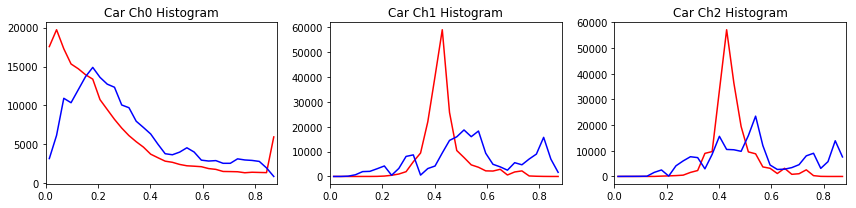

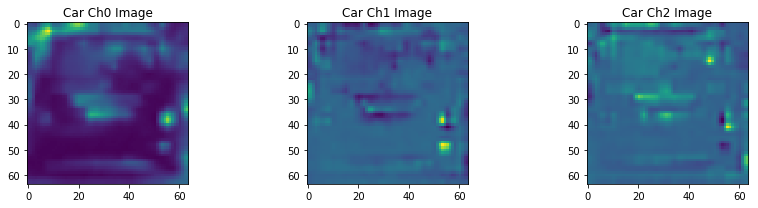

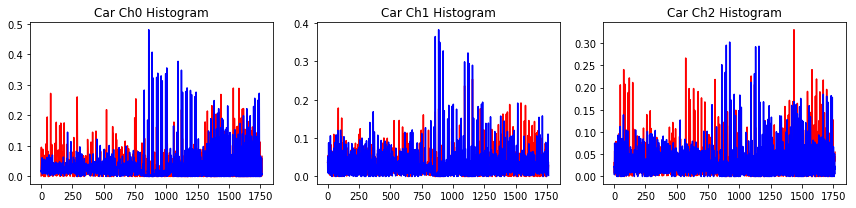

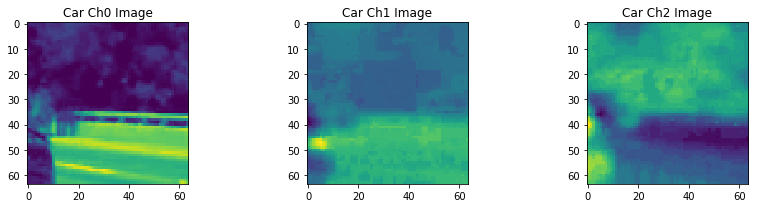

In [15]:
colorSpaceCompare('YCrCb')

Looking at the above plots I can see that in the YCrCb colour space channels 1 and 2 show a marked difference in the colour histograms. This shows itself as a spike in the data that does not appear for the no car data. The first channel shows a recognisable vehicle. Therefore I will use the first channel for a HOG classifier and the second channel and third channels for colour classification.

I think I have enough here to start building a classifier.

In [16]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
#    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space=='HSV':
            feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        elif color_space=='LUV':
            feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
        elif color_space =='LAB':
            feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
        elif color_space =='YCrCb':
            feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
        elif color_space =='HLS':
            feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        elif color_space =='YUV':
            feature_image=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        else:
            feature_image=img
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int((img.shape[0]/2)+75)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]-100
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    i=0
    j=4
    for ys in range(10):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = y_start_stop[0]-int(xy_window[1]/6)+ i*ny_pix_per_step
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
        if i==j:
            xy_window=np.multiply(xy_window,2).astype(int)   
            nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))    
            ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
            # Compute the number of windows in x/y
            nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
            ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
            nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
            ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
            j-=1
            i=-1
        i+=1
        # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [17]:
from sklearn.cross_validation import train_test_split
sample_size = 8792
cars = car[0:sample_size]
notcars = noCar[0:sample_size]


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 11236
15.71 Seconds to train SVC...
Test Accuracy of SVC =  0.9886


In [18]:
def TestImage(image):
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    return window_img, hot_windows

In [19]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


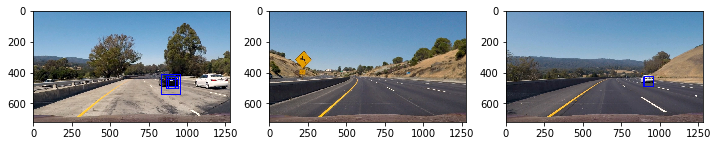

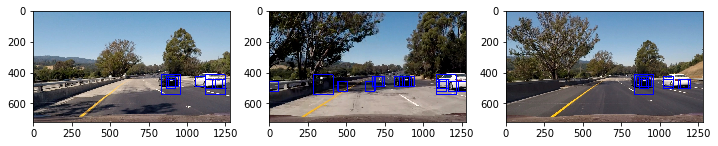

In [20]:
fig = plt.figure(figsize=(12,3))
j=1
for imageFile in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(imageFile)
    imageBox,_=TestImage(image)
    if j > 3:
        fig = plt.figure(figsize=(12,3))
        j=1
    pltNo=int(str(13)+str(j))
    plt.subplot(pltNo)
    plt.imshow(imageBox)
    j+=1

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


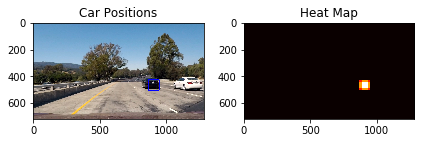

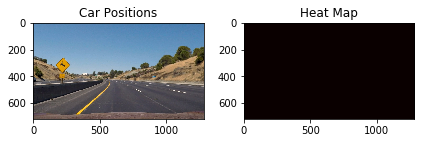

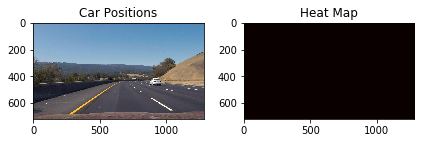

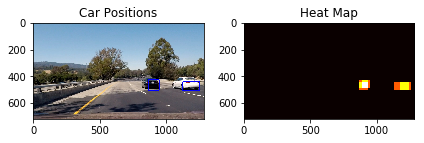

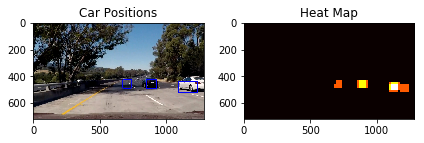

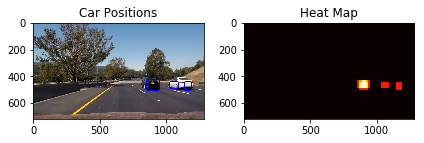

In [21]:
fig = plt.figure(figsize=(12,3))
i=1
for imageFile in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(imageFile)
    imageBox,hot_windows=TestImage(image)
    if i > 3:
        fig = plt.figure(figsize=(12,3))
        i=1
    pltNo=int(str(13)+str(i))

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

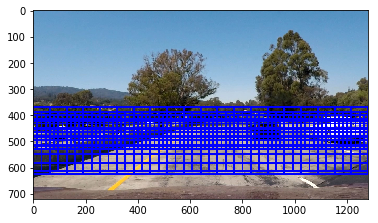

In [22]:
image = mpimg.imread('test_images/test1.jpg')
bboxes=slide_window(image, x_start_stop=[0, image.shape[1]], y_start_stop=[int((image.shape[0]/2)+50), image.shape[0]-150], xy_window=(64, 64), xy_overlap=(0.75, 0.75))
imbox= draw_boxes(image,bboxes)
plt.imshow(imbox)

In [36]:
class videoHeatMap():
    def __init__ (self):
        self.queueMaxLen = 10
        self.lastHeatMap = []
        
    def addHeat(self,boxes):
        if (len(self.lastHeatMap)>self.queueMaxLen):
            self.lastHeatMap.pop(0)
        self.lastHeatMap.append(boxes)
        
    def readHeat(self,heatmap):
        # Iterate through list of bboxes
        for box in self.lastHeatMap:
            heatmap=np.add(heatmap,np.asarray(box))
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

In [37]:
videoHeatMap=videoHeatMap()

In [38]:
def videoProcess(image):
   
    imageBox,hot_windows=TestImage(image)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list

    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives from current image
    heat = apply_threshold(heat,1)

    #Add heat map to video heat map class
    videoHeatMap.addHeat(heat)
    
    #create empty heat map image
    videoHeat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    #fill Heat Map with video heat map
    videoHeat = videoHeatMap.readHeat(videoHeat)
    
    #Threshold video Heat Map
    heat = apply_threshold(videoHeat,10)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [39]:
#fig = plt.figure(figsize=(12,3))
#i=1
#for imageFile in glob.glob('test_images/*.jpg'):
#    image = mpimg.imread(imageFile)
#    draw_img=videoProcess(image)
#    if i > 3:
#        fig = plt.figure(figsize=(12,3))
#        i=1
#    pltNo=int(str(13)+str(i))


#    fig = plt.figure()
#    plt.subplot(121)
#    plt.imshow(draw_img)
#    plt.title('Car Positions')
#    fig.tight_layout()

In [40]:
from moviepy.editor import VideoFileClip

#clipIn = VideoFileClip('test_video.mp4')
#clipOut = clipIn.fl_image(videoProcess)
#clipOut.write_videofile('test_video_processed.mp4')

In [41]:
clipIn = VideoFileClip('project_video.mp4')
clipOut = clipIn.fl_image(videoProcess)
clipOut.write_videofile('project_video_processed.mp4')

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing audio in project_video_processedTEMP_MPY_wvf_snd.mp3


100%|████████████████████████████████████| 1112/1112 [00:00<00:00, 1293.02it/s]


[MoviePy] Done.
[MoviePy] Writing video project_video_processed.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:14:57<00:03,  3.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 



In [ ]:
del clipIn.reader
del clipIn